# Model of a COVID-19 outbreak
by Ulf R. Pedersen

We wish to model the spread of an epidemic disease similar to the COVID-19 outbreak. It is assumed that a given individual can be in one of the following states:

* **S**usceptible ($S$)
* **E**xposed ($E$)
* Infectious **H**ealthy ($H$)
* Infectious **I**ll ($I$)
* **R**ecovered ($R$)
* **D**ead ($D$)

This model explicitly split the group of infectious into two groups to emphisise the role of the "shadow number" COVID-19 outbreak. The group infectious healthy, $H$ have no or mild symptoms, while the group of infectious ill $I$ individual have serious symptoms that may be fatel.

A few individuals will be infected without symptoms ($H$) in the initial state of the population, and the remaining individuals will be susceptible ($S$). An exposed individual ($E$) cannot spread the desice, while an infectious healthy ($H$) or a ill ($I$) individial can. 

The state of the population progress in steps of one day using the below set of rules:

1. An exposed individual ($E$) becomes infectious healthy ($H$); $\sigma$.
2. A infectious healthy ($H$) individual infect a susceptible individual ($S$); $f\beta_H$.
3. A infectious healthy ($H$) individual become ill ($I$); $\alpha$.
4. A infectious healthy ($H$) individual recover ($R$); $\gamma_H$.
5. An ill individual ($I$) infect a susceptible individual ($S$); $f\beta_I$.
6. An ill individual ($I$) recover ($R$); $\gamma_I$.
7. An ill individual ($I$) dies ($D$); $g\gamma_D$.

The model can be written in the form of a set of differential equations:
$$
\begin{aligned}
 \dot S &= -f\beta_H HS - f\beta_I IS \\
 \dot E &= +f\beta_H HS + f\beta_I IS - \sigma E \\
 \dot H &= \sigma E - \alpha H - \gamma_H H \\
 \dot I &= \alpha H - \gamma_I I - s_\gamma\gamma_D I \\
 \dot R &=  \gamma_H H + \gamma_I I \\
 \dot D &= g\gamma_D I \\
\end{aligned}
$$
The variables are normalised for simplcity: $S+E+H+I+R+D=1$.

The parameters $\sigma$, $\beta_H$, $\alpha$, $\gamma_H$, $\beta_I$, $\gamma_I$ and $\gamma_D$ with $f=g=1$ ar are chosen to mimic an hypothetical uncontroled COVID-19 outbreak. 
The *society* parameters, $f(I)$ and $g(I)$, are used to model the societies response to the epidemic. They model *social distancing* and *collapse of healthcare*, respectively, and are functions of the number of ill individuals, $I$. If the number of ill individuals are below a certain tresshold, $I<I_\beta$ and $I<I_\gamma$, then $f=g=1$, and else $f=f_0<1$ and $g=g_0>1$. This introduces four additional parameters to the model, $I_\beta$, $I_\gamma$, $f_0$ and $g_0$. Thus, this model has a total of 11 parameters.

First we will investigate the model of a uncontroled outbreak, where $f=g=1$ always. Italy is used as case for the parameter estimation.

R0_H = 2.333
R0_I = 2.309


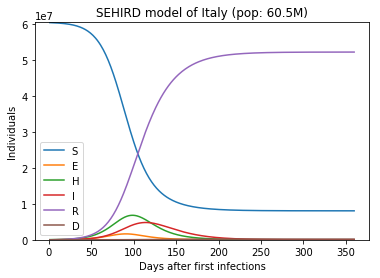

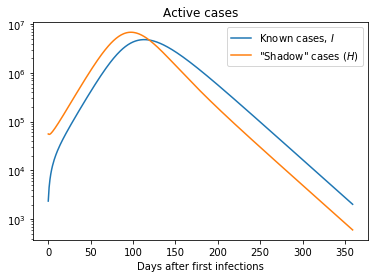

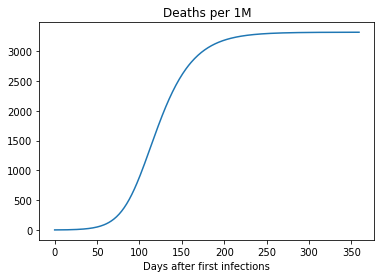

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import array
from scipy.integrate import ode

# Define model
def f(t, y, args):
    S, E, H, I, R, D = y
    sigma, beta_H, alpha, gamma_H, beta_I, gamma_I, gamma_D, I_beta, I_gamma, f_0, g_0  = args
    f = 1.0
    g = 1.0
    if I>I_beta:
        f = f_0
    if I>I_gamma:
        g = g_0
    dS = -f*beta_H*H*S-f*beta_I*I*S
    dE = +f*beta_H*H*S+f*beta_I*I*S-sigma*E 
    dH = sigma*E-alpha*H-gamma_H*H
    dI = alpha*H-gamma_I*I-g*gamma_D*I
    dR = gamma_H*H+gamma_I*I
    dD = g*gamma_D*I
    return [dS, dE, dH, dI, dR, dD]
model = ode(f)
#model.set_integrator('vode',method='bdf')
model.set_integrator('lsoda')

# Model parameters
#      0      1       2      3        4       5        6         7       8        9    10
#      sigma, beta_H, alpha, gamma_H, beta_I, gamma_I, gamma_D,  I_beta, I_gamma, f_0, g_0
args = 1/2,   1/6,    1/24,  1/14,    1/9,    1/21,    1/2000,   1,      1,       1,   1
model.set_f_params(args)

# Compute R0 values from parameters
beta_H = args[1]
gamma_H = args[3]
print(f'R0_H = {beta_H/gamma_H:1.3f}')
# Derived quantatoes
beta_I = args[4]
gamma_I = args[5]
gamma_D = args[6]
print(f'R0_I = {beta_I/(gamma_I+gamma_D):1.3f}')

# Set initial values
y = 1-1e-3, 0, 1e-3, 0, 0, 0
model.set_initial_value(y,0.0)

# Solve model
def compute(model, number_of_months = 12):
    total_number_of_days = 30*number_of_months
    t, S, E, H, I, R, D = [], [], [], [], [], [], []
    for time in range(1,total_number_of_days+1):
        y = model.integrate(time)
        t.append(time)
        S.append(y[0])
        E.append(y[1])
        H.append(y[2])
        I.append(y[3])
        R.append(y[4])
        D.append(y[5])
    return t, S, E, H, I, R, D

t, S, E, H, I, R, D = compute(model)

# Plot result
I_beta = args[7]
I_gamma = args[8]
plt.figure()
plt.title(f'SEHIRD model')
plt.plot(t,array(S),label='$S$')
plt.plot(t,array(E),label='$E$')
plt.plot(t,array(H),label='$H$')
plt.plot(t,array(I),label='$I$')
plt.plot(t,array(R),label='$R$')
plt.plot(t,array(D),label='$D$')
plt.plot([0, max(t)],[I_beta, I_beta],'--',label=r'$I_\beta$')
plt.plot([0, max(t)],[I_gamma, I_gamma],'--',label=r'$I_\gamma$')
plt.yscale('log')
plt.xlabel('Days after first infections')
plt.ylabel('Fraction of individuals')
plt.legend()
#plt.legend('SEHIRD')
plt.show()    
    
# Plot result
country, population_size='Italy', 60.46e6
plt.figure()
plt.title(f'SEHIRD model of {country} (pop: {population_size/1e6:1.1f}M)')
plt.plot(t,array(S)*population_size)
plt.plot(t,array(E)*population_size)
plt.plot(t,array(H)*population_size)
plt.plot(t,array(I)*population_size)
plt.plot(t,array(R)*population_size)
plt.plot(t,array(D)*population_size)
#plt.yscale('log')
plt.ylim(1,population_size)
plt.xlabel('Days after first infections')
plt.ylabel('Individuals')
plt.legend('SEHIRD')
plt.show()

# Active cases
plt.figure()
plt.title(f'Active cases')
known_active_cases = array(I)*population_size
unknown_active_cases = array(H)*population_size
plt.plot(known_active_cases)
plt.plot(unknown_active_cases)
plt.legend([r'Known cases, $I$',r'"Shadow" cases ($H$)'])
#plt.ylim(0,max(known_active_cases))
plt.yscale('log')
plt.xlabel('Days after first infections')
plt.show()

# Plot deaths per one million
plt.figure()
plt.title('Deaths per 1M')
deaths_per_one_million = array(D)*1e6
plt.plot(deaths_per_one_million)
plt.xlabel('Days after first infections')
plt.show()

Next we will compare with a simulation with *social distancing*

In [2]:
plt.figure()
plt.title('Cases')

# Simulate the uncontrolled case (same as above)
#      0      1       2      3        4       5        6         7       8        9    10
#      sigma, beta_H, alpha, gamma_H, beta_I, gamma_I, gamma_D,  I_beta, I_gamma, f_0, g_0
args = 1/2,   1/6,    1/24,  1/14,    1/9,    1/21,    1/2000,   1,      1,       1,   1
model.set_f_params(args)
y = 1-1e-3, 0, 1e-3, 0, 0, 0
model.set_initial_value(y,0.0)
t, S, E, H, I, R, D = compute(model)
plt.plot(array(I),'r-',label='Uncontrolled epidemic')

# Simulate the controlled case
#      0      1       2      3        4       5        6         7       8        9    10
#      sigma, beta_H, alpha, gamma_H, beta_I, gamma_I, gamma_D,  I_beta, I_gamma, f_0, g_0
args = 1/2,   1/6,    1/24,  1/14,    1/9,    1/21,    1/2000,   1e-3,   1,      0.6, 1
model.set_f_params(args)
y = 1-1e-3, 0, 1e-3, 0, 0, 0
model.set_initial_value(y,0.0)
t, S, E, H, I, R, D = compute(model)
plt.plot(array(I),'g-',label='Controlled epidemic')

# Finish plot
plt.ylabel('Fraction of population')
plt.legend()
plt.yscale('log')
plt.xlabel('Days after first infections')
plt.show()

# Compute R0 values from parameters
f = args[9]
beta_H = args[1]
gamma_H = args[3]
print(f'Controlled epidemic: R0_H = {f*beta_H/gamma_H:1.3f}')
# Derived quantatoes
beta_I = args[4]
gamma_I = args[5]
gamma_D = args[6]
print(f'Controlled epidemic: R0_I = {f*beta_I/(gamma_I+gamma_D):1.3f}')

Controlled epidemic: R0_H = 1.400
Controlled epidemic: R0_I = 1.385
